# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Check torch version and CUDA status if GPU is enabled.
print(torch.__version__)
print(torch.cuda.is_available()) # Should return True when GPU is enabled. 

# Use GPU if it's available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

2.9.1
False
mps


## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [ ]:
# Define transforms
# Training transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Test transforms without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True
)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=128,
    shuffle=False
)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


deer


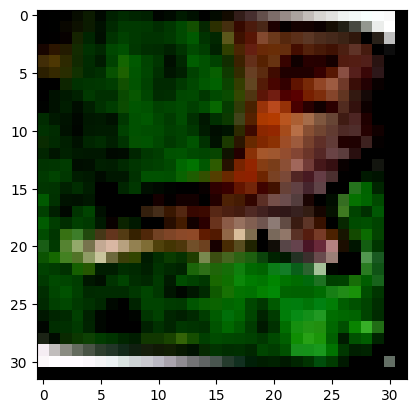

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92156863].


car


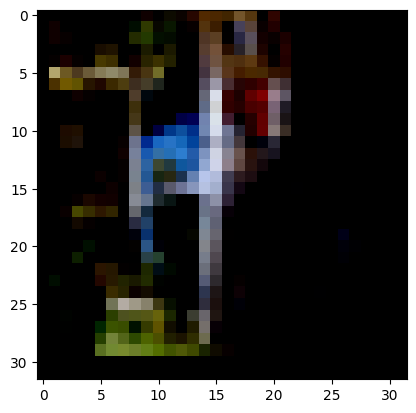

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


car


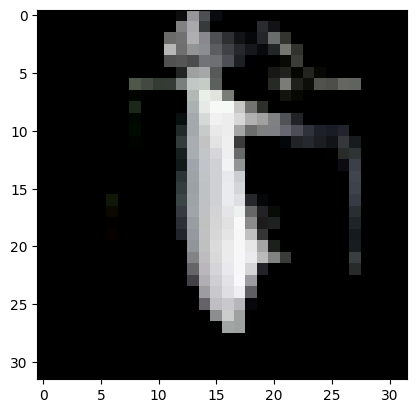

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.81960785].


car


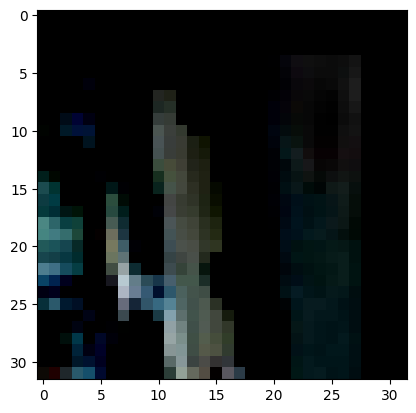

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


truck


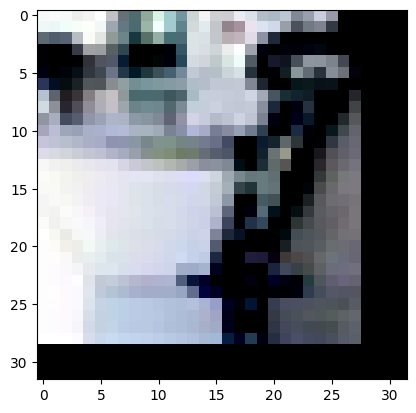

In [4]:
# Explore data
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [5]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # 3 input channels (RGB) → 32 filters
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # 32 → 64 filters
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # 64 → 128 filters
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)                   # Halves spatial dimensions
        
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 8, 10)           # Flatten and classify to 10 classes
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1: 32x32x3 → 32x32x32 → 16x16x32
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # Conv block 2: 16x16x32 → 16x16x64
        x = F.relu(self.conv2(x))
        
        # Conv block 3: 16x16x64 → 16x16x128 → 8x8x128
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten and classify
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(x)
        x = self.fc1(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
print(f'Using device: {device}')

# Instantiate the model
model = CustomModel()
model.to(device)

# Loss function / Optimzer - CrossEntropyLoss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

Using device: mps


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:
# Number of epochs to train
n_epochs = 50

# Track loss per epoch
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels, move to device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        epoch_loss += loss.item()
        
        # Print every 250 batches
        if (i + 1) % 250 == 0:
            print(f'Epoch [{epoch + 1}/{n_epochs}], Batch [{i + 1}], Loss: {running_loss / 250:.4f}')
            running_loss = 0.0
    
    # Record average training loss for this epoch
    avg_train_loss = epoch_loss / len(trainloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(testloader)
    test_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch + 1}/{n_epochs}] complete. Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

print('Training complete!')

Epoch [1/50], Batch [250], Loss: 1.7252
Epoch [1/50] complete. Train Loss: 1.6236, Val Loss: 1.2705
Epoch [2/50], Batch [250], Loss: 1.3414
Epoch [2/50] complete. Train Loss: 1.3067, Val Loss: 1.1008
Epoch [3/50], Batch [250], Loss: 1.1695
Epoch [3/50] complete. Train Loss: 1.1508, Val Loss: 0.9817
Epoch [4/50], Batch [250], Loss: 1.0756
Epoch [4/50] complete. Train Loss: 1.0668, Val Loss: 0.8721
Epoch [5/50], Batch [250], Loss: 1.0081
Epoch [5/50] complete. Train Loss: 1.0013, Val Loss: 0.8337
Epoch [6/50], Batch [250], Loss: 0.9537
Epoch [6/50] complete. Train Loss: 0.9525, Val Loss: 0.8031
Epoch [7/50], Batch [250], Loss: 0.9218
Epoch [7/50] complete. Train Loss: 0.9150, Val Loss: 0.7748
Epoch [8/50], Batch [250], Loss: 0.8811
Epoch [8/50] complete. Train Loss: 0.8815, Val Loss: 0.7260
Epoch [9/50], Batch [250], Loss: 0.8613
Epoch [9/50] complete. Train Loss: 0.8541, Val Loss: 0.7304
Epoch [10/50], Batch [250], Loss: 0.8310
Epoch [10/50] complete. Train Loss: 0.8236, Val Loss: 0.703

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt

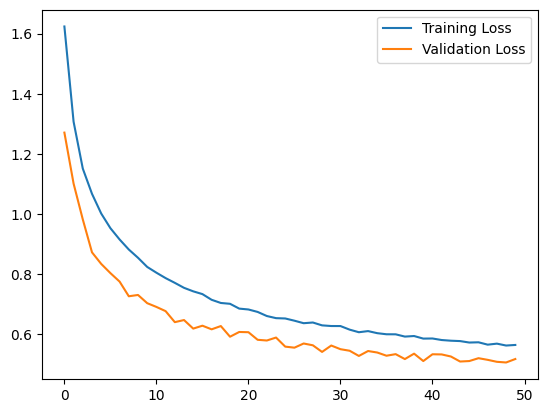

In [8]:
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.legend()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [9]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 82.58%


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'cifar10_model.pth')

print('Model saved to cifar10_model.pth')

Model saved to cifar10_model.pth


In [11]:
# Load the saved model
loaded_model = CustomModel()
loaded_model.load_state_dict(torch.load('cifar10_model.pth'))
loaded_model.to(device)
loaded_model.eval()

print('Model loaded from cifar10_model.pth')

# Test the loaded model
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = loaded_model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Loaded model accuracy on test set: {accuracy:.2f}%')

Model loaded from cifar10_model.pth
Loaded model accuracy on test set: 82.58%


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would say build the model. I wasn't able to break into the 60% range with a fully connected network. Once I switched to using a CNN I was able to break into the 70% range. When I added a 3rd layer, increased the number of epochs and tuned the learning rate I was able to get 82.5%!
